In [3]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action="ignore")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 여기에서 데이터 선택 -> 자동화 부탁

In [5]:
total_df = pd.read_csv('../../data/merged_final.csv', index_col=0)

In [50]:
total_df[["air_GW",total_df.columns[-4]]]

,air_GW,GW_demand
0,42.0,0.592
1,43.0,0.840
2,34.0,0.828
3,44.0,0.792
4,64.0,0.818
...,...,...
1456,23.0,3.830
1457,42.0,4.510
1458,54.0,4.490
1459,26.0,4.444


In [51]:
def sample_multivariate(amount, total_df, target_df_columns):
    samples = []
    # 데이터프레임을 하나로 통합
    df = total_df[target_df_columns]
    columns = df.columns
    if amount == 0:
        # y값만 리턴
        samples.append(df)
    elif amount == 1:
        # sample을 한 column씩 추출
        for index in range(len(columns) - 1):
            sample = df[[columns[index], columns[-1]]]
            samples.append(sample)
    elif amount == 2:
        # sample을 두 column씩 추출
        for first_index in range(len(columns)-1):
            remaining_columns = columns[first_index+1:-1]
            for second_index in range(len(remaining_columns)):
                targets = [columns[first_index],remaining_columns[second_index],columns[-1]]
                sample = df[targets]
                samples.append(sample)
    return samples

In [52]:
def split_sample(df):
    train = df.iloc[:1096]
    test = df.iloc[1096:]
    return {"train":train, "test":test}

In [66]:
samples = sample_multivariate(1,total_df,['air_GW', 'real_pop_GW', 'pop_GW', 'pop_male_GW', 'pop_female_GW',
       'mvpop_GW', 'station_GW', 'GW_demand'])

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()


In [69]:
scaled = []
for sample in samples:
    train_set = split_sample(sample)["train"]
    test_set = split_sample(sample)["test"]
    # Input scale
    scaler_x.fit(sample.iloc[:, :-1])
    train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
    test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])
    # Output scale
    scaler_y.fit(train_set.iloc[:, [-1]])
    train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
    test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])
    scaled.append({"train":train_set,"test":test_set})
samples = scaled



In [ ]:
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [70]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100

In [ ]:
# 설정값
data_dim = len(samples[0]["train"].columns)
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 500

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [ ]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [ ]:
for index, sample in enumerate(samples):
    trainX, trainY = build_dataset(np.array(train_set), seq_length)
    testX, testY = build_dataset(np.array(test_set), seq_length)

    # 텐서로 변환
    trainX_tensor = torch.FloatTensor(trainX)
    trainY_tensor = torch.FloatTensor(trainY)
    testX_tensor = torch.FloatTensor(testX)
    testY_tensor = torch.FloatTensor(testY)

    # 텐서 형태로 데이터 정의
    dataset = TensorDataset(trainX_tensor, trainY_tensor)

    # 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
    dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)
    device = torch.device('cpu')
    net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
    model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

    # 모델 저장    
    PATH = f"./Timeseries_LSTM_data-02-{index}.pth"
    torch.save(model.state_dict(), PATH)

In [ ]:
# epoch별 손실값
# fig = plt.figure(figsize=(10, 4))
# plt.plot(train_hist, label="Training loss")
# plt.legend()
# plt.show()

In [78]:
# 불러오기
PATH = "./Timeseries_LSTM_data-02-0.pth"
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

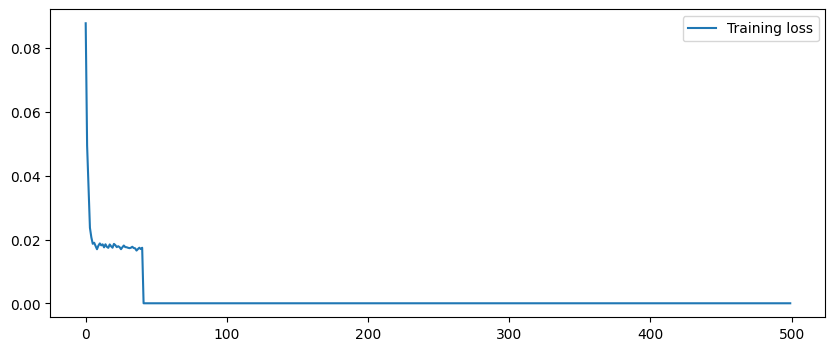

Net(
  (lstm): LSTM(2, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  1.834127604177201


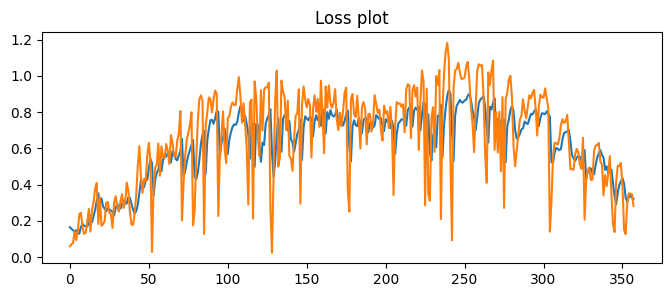

In [43]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred)), pred, label = 'pred')
plt.plot(np.arange(len(testY)), testY, label = 'true')
plt.title("Loss plot")
plt.show()